In [1]:
%load_ext autoreload
%autoreload 2


torch.Size([513, 105])


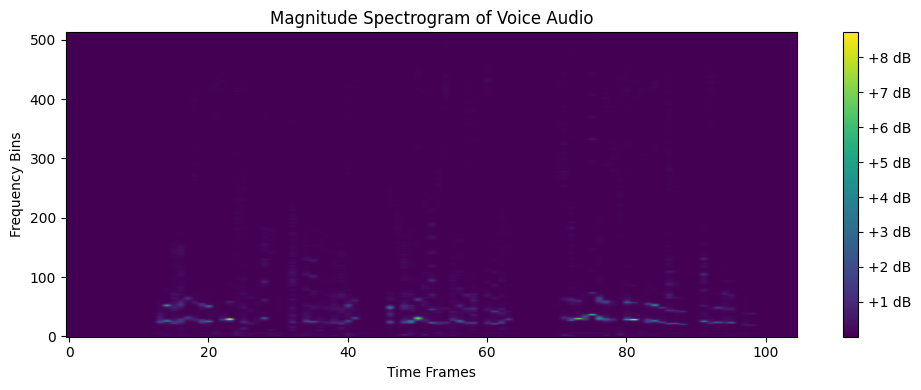

In [ ]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from audiosep.data import wav_to_mag_phase, SR


In [8]:
def analyze_triplet(folder, title_prefix=""):
    base = "../audio_samples/" + folder
    mix_path = base + "/mix.wav"
    target_path = base + "/voice.wav"
    pred_path = base + "/predicted.wav"

    print("=" * 80)
    print(f"{title_prefix}Folder: {folder}")
    print("=" * 80)

    # ---- Waveform loading ----
    mix, sr = librosa.load(mix_path, sr=SR, mono=True)
    target, _ = librosa.load(target_path, sr=SR, mono=True)
    pred, _ = librosa.load(pred_path, sr=SR, mono=True)

    # Align lengths
    min_len = min(len(mix), len(target), len(pred))
    mix = mix[:min_len]
    target = target[:min_len]
    pred = pred[:min_len]
    error = pred - target

    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {min_len / sr:.2f} s")
    print(f"Mean abs error: {np.mean(np.abs(error)):.4e}")
    print(f"RMSE (time-domain): {np.sqrt(np.mean(error**2)):.4e}")
    print(f"Max abs error: {np.max(np.abs(error)):.4f}")
    print(f"Std of error: {np.std(error):.4e}")
    print(f"Correlation(pred, target): {np.corrcoef(pred, target)[0, 1]:.4f}")

    thr = 3 * np.std(error)
    frac_outliers = np.mean(np.abs(error) > thr)
    print(f"Fraction of samples with |error| > 3σ: {frac_outliers:.4%}")

    # ---- Histograms ----
    fig, axs = plt.subplots(1, 3, figsize=(15, 3))
    axs[0].hist(target, bins=100, alpha=0.7, color="C0")
    axs[0].set_title(f"{title_prefix}Target samples")
    axs[1].hist(pred, bins=100, alpha=0.7, color="C1")
    axs[1].set_title(f"{title_prefix}Predicted samples")
    axs[2].hist(error, bins=100, alpha=0.7, color="C2")
    axs[2].set_title(f"{title_prefix}Error (pred - target)")
    for ax in axs:
        ax.set_xlabel("Amplitude")
        ax.set_ylabel("Count")
    plt.tight_layout()
    plt.show()

    # ---- Waveform (first second) ----
    t = np.arange(min_len) / sr
    t_zoom = t[t < 1.0]
    idx_zoom = len(t_zoom)

    plt.figure(figsize=(10, 3))
    plt.plot(t_zoom, target[:idx_zoom], label="Target", alpha=0.8)
    plt.plot(t_zoom, pred[:idx_zoom], label="Predicted", alpha=0.8)
    plt.title(f"{title_prefix}Waveforms (first second)")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- Frame-wise RMS error ----
    frame_length = int(0.02 * sr)
    hop_length = int(0.01 * sr)
    rms_err = librosa.feature.rms(
        y=error, frame_length=frame_length, hop_length=hop_length
    )[0]
    times = librosa.frames_to_time(
        np.arange(len(rms_err)), sr=sr, hop_length=hop_length
    )

    plt.figure(figsize=(10, 3))
    plt.plot(times, rms_err)
    plt.title(f"{title_prefix}Frame-wise RMS error over time")
    plt.xlabel("Time [s]")
    plt.ylabel("RMS error")
    plt.tight_layout()
    plt.show()

    # ---- Spectrogram-based metrics ----
    mag_mix, _ = wav_to_mag_phase(mix_path)
    mag_target, _ = wav_to_mag_phase(target_path)
    mag_pred, _ = wav_to_mag_phase(pred_path)

    mag_mix = mag_mix.numpy()
    mag_target = mag_target.numpy()
    mag_pred = mag_pred.numpy()

    T = min(mag_mix.shape[1], mag_target.shape[1], mag_pred.shape[1])
    mag_mix = mag_mix[:, :T]
    mag_target = mag_target[:, :T]
    mag_pred = mag_pred[:, :T]

    eps = 1e-8
    spec_err = mag_pred - mag_target
    spectral_convergence = np.linalg.norm(spec_err) / (np.linalg.norm(mag_target) + eps)
    log_mag_target = np.log10(mag_target + eps)
    log_mag_pred = np.log10(mag_pred + eps)
    lsd = np.sqrt(np.mean((log_mag_target - log_mag_pred) ** 2))

    print(f"Spectral convergence: {spectral_convergence:.4e}")
    print(f"Log-spectral distance (RMS): {lsd:.4f}")

    fig, axs = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

    im0 = axs[0].imshow(20 * np.log10(mag_mix + eps), aspect="auto", origin="lower")
    axs[0].set_title(f"{title_prefix}Mix (magnitude, dB)")
    plt.colorbar(im0, ax=axs[0], format="%+2.0f dB")

    im1 = axs[1].imshow(20 * np.log10(mag_target + eps), aspect="auto", origin="lower")
    axs[1].set_title(f"{title_prefix}Target voice (magnitude, dB)")
    plt.colorbar(im1, ax=axs[1], format="%+2.0f dB")

    im2 = axs[2].imshow(20 * np.log10(mag_pred + eps), aspect="auto", origin="lower")
    axs[2].set_title(f"{title_prefix}Predicted voice (magnitude, dB)")
    plt.colorbar(im2, ax=axs[2], format="%+2.0f dB")

    im3 = axs[3].imshow(np.abs(spec_err), aspect="auto", origin="lower")
    axs[3].set_title(f"{title_prefix}|Predicted - Target| (spectrogram error)")
    plt.colorbar(im3, ax=axs[3])

    axs[3].set_xlabel("Time frames")
    for ax in axs:
        ax.set_ylabel("Frequency bins")

    plt.tight_layout()
    plt.show()


[Skip 2D] Folder: spectro_unet_skip_2d
Sample rate: 8000 Hz
Duration: 9.98 s
Mean abs error: 1.7442e-02
RMSE (time-domain): 2.1891e-02
Max abs error: 0.0943
Std of error: 2.1891e-02
Correlation(pred, target): 0.5308
Fraction of samples with |error| > 3σ: 0.3468%


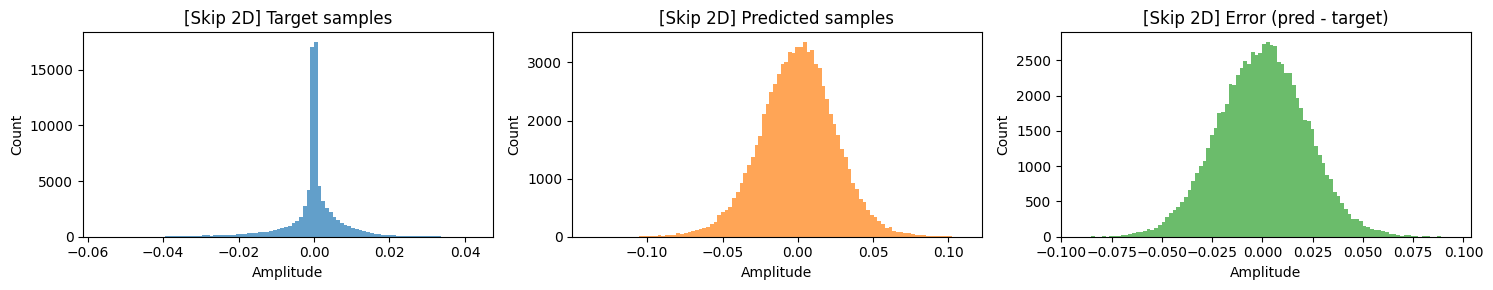

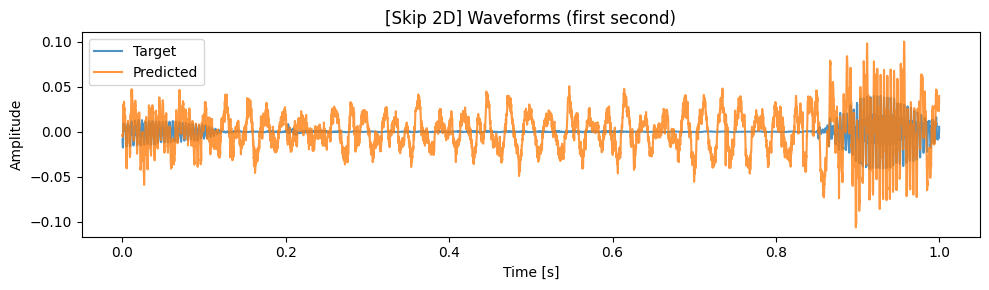

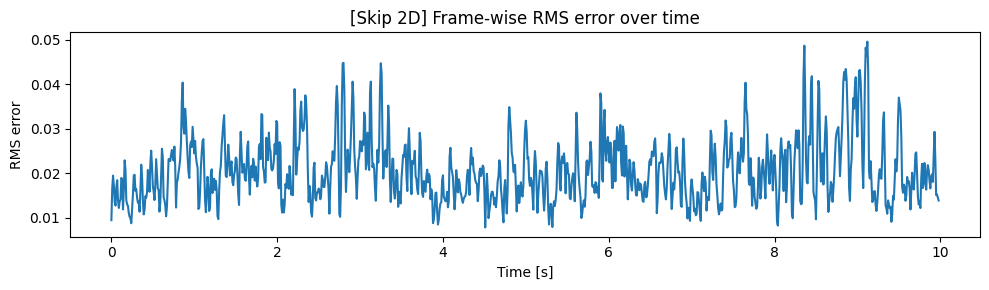

Spectral convergence: 2.9122e+00
Log-spectral distance (RMS): 1.1998


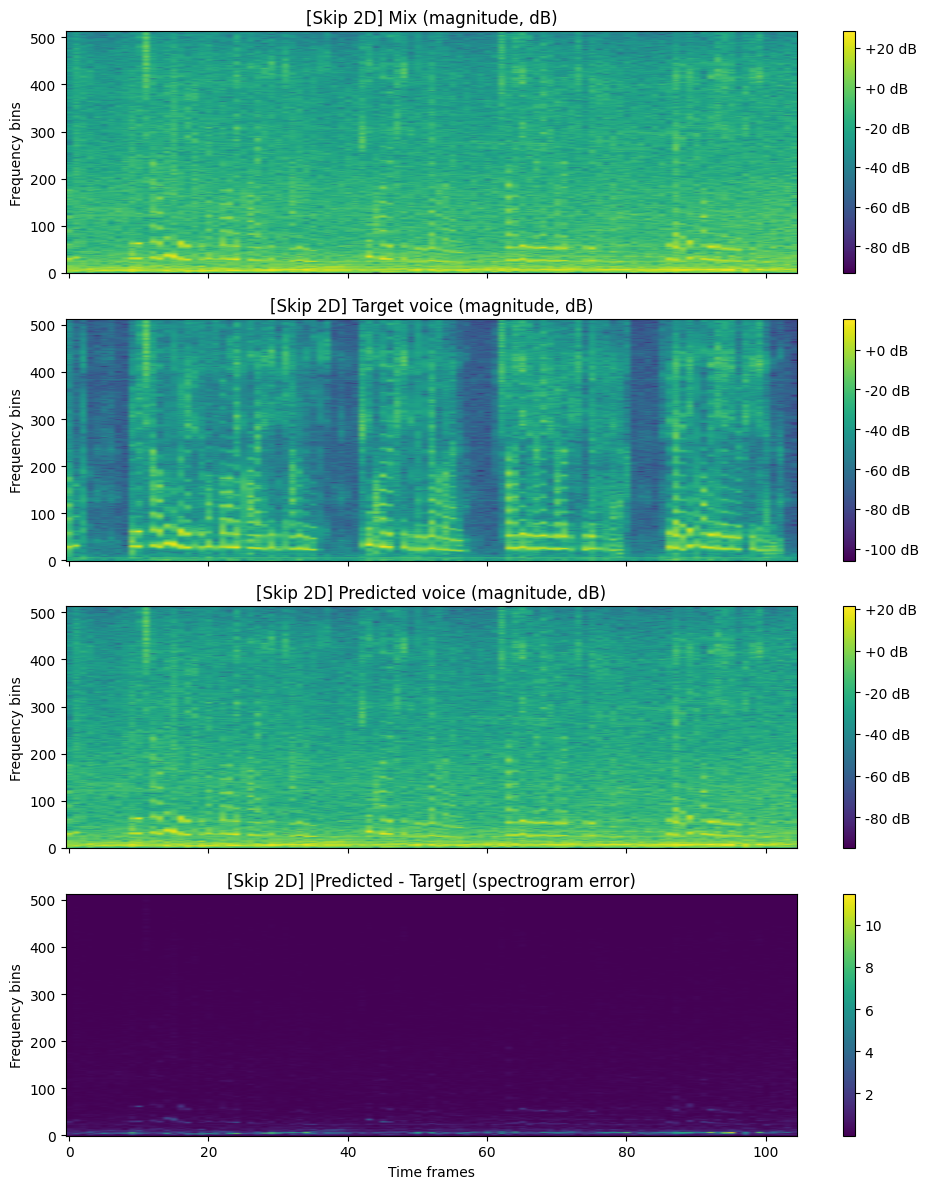

[Spectro Orig] Folder: spectro_unet_orig
Sample rate: 8000 Hz
Duration: 9.98 s
Mean abs error: 2.1093e-03
RMSE (time-domain): 3.1275e-03
Max abs error: 0.0215
Std of error: 3.1275e-03
Correlation(pred, target): 0.9312
Fraction of samples with |error| > 3σ: 1.8154%


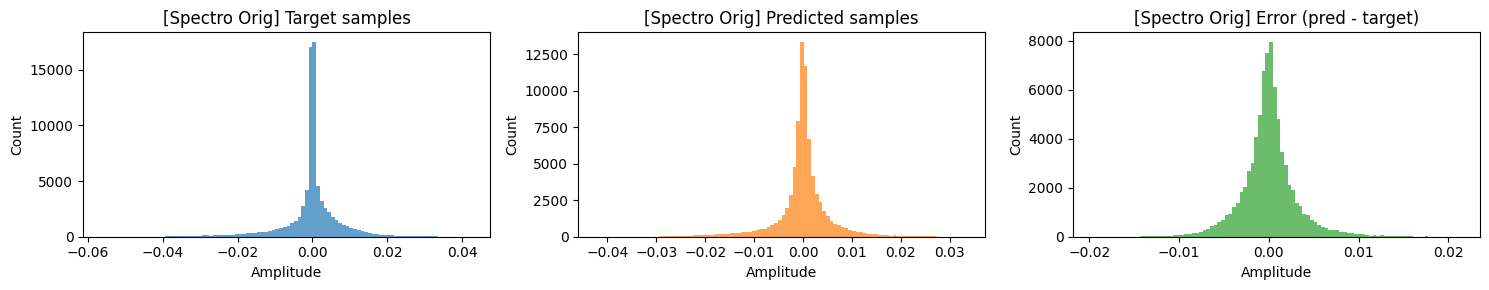

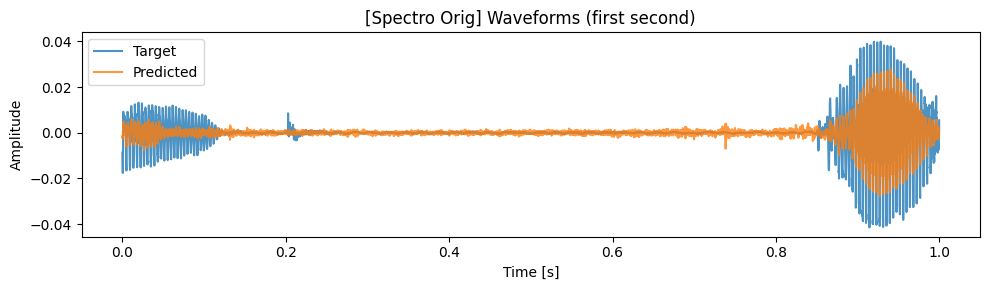

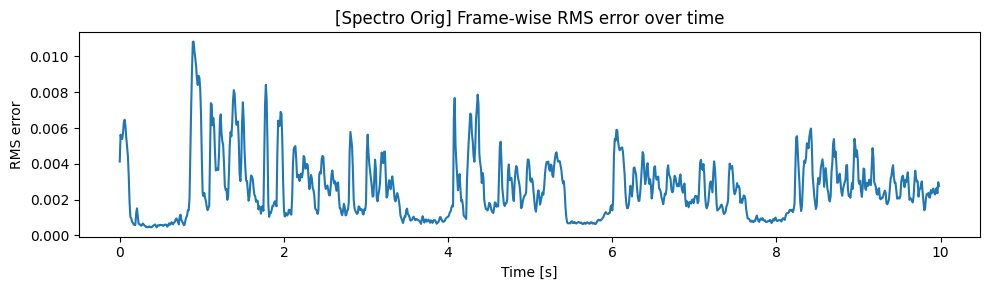

Spectral convergence: 3.5890e-01
Log-spectral distance (RMS): 0.7435


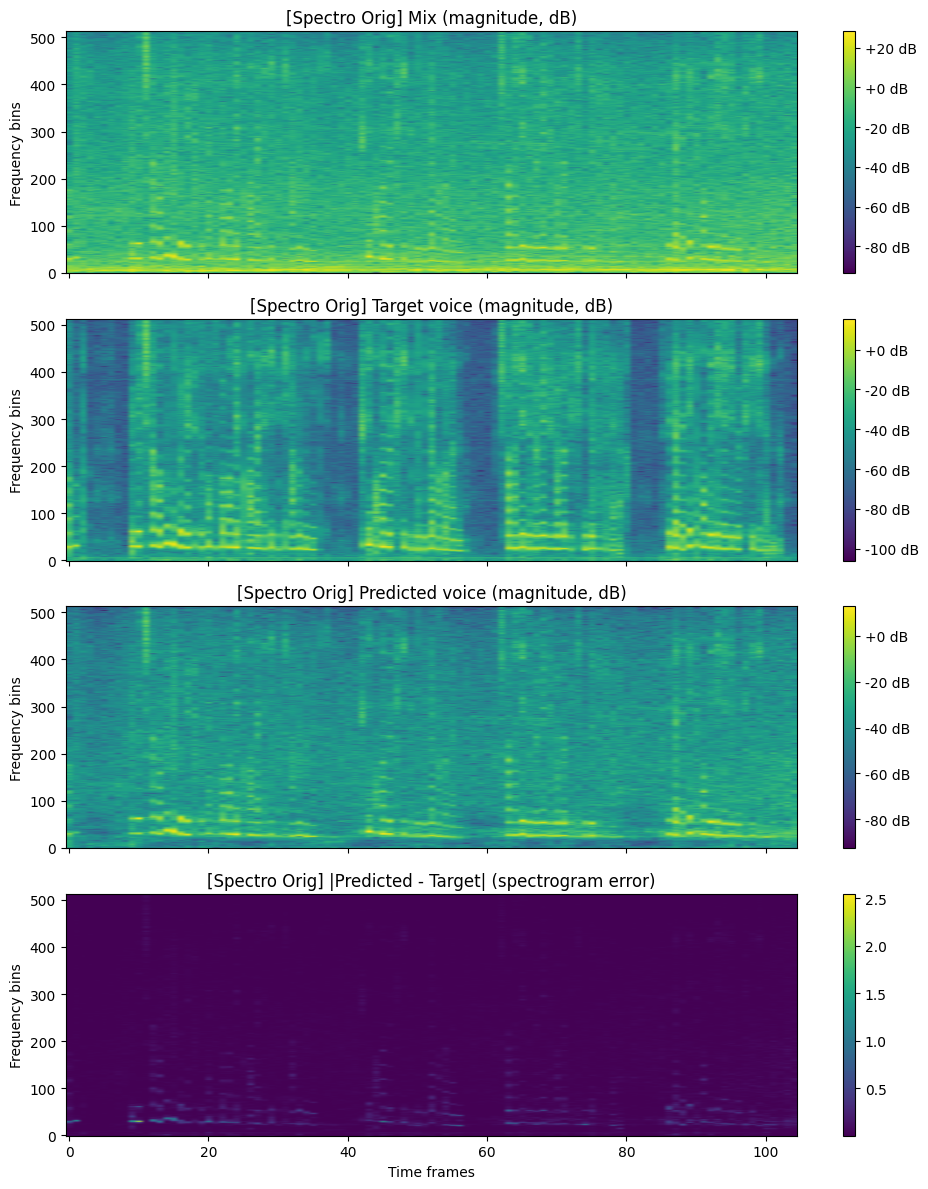

[WaveUNet] Folder: wave_unet
Sample rate: 8000 Hz
Duration: 10.00 s
Mean abs error: 1.0899e-01
RMSE (time-domain): 1.2178e-01
Max abs error: 0.5220
Std of error: 7.4671e-02
Correlation(pred, target): -0.9732
Fraction of samples with |error| > 3σ: 4.5288%


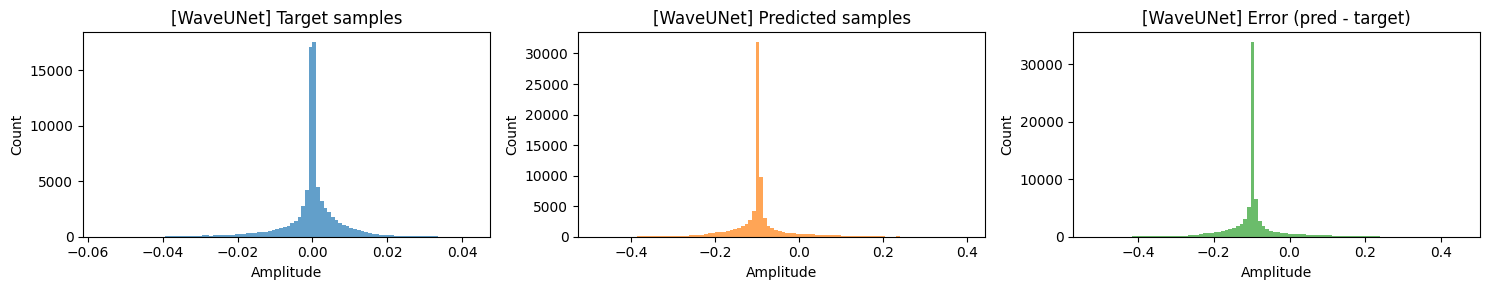

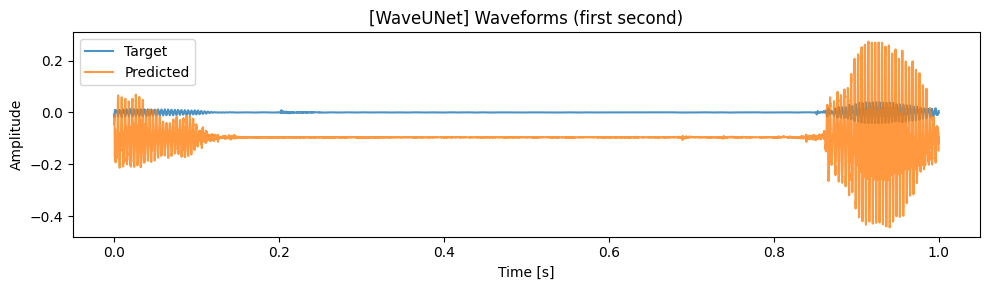

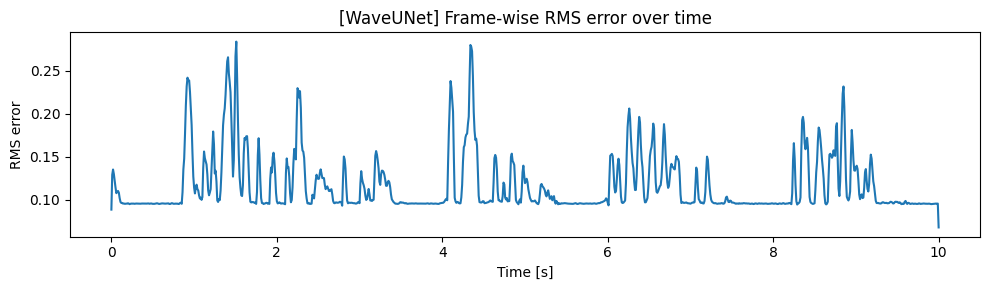

Spectral convergence: 1.8083e+01
Log-spectral distance (RMS): 1.1078


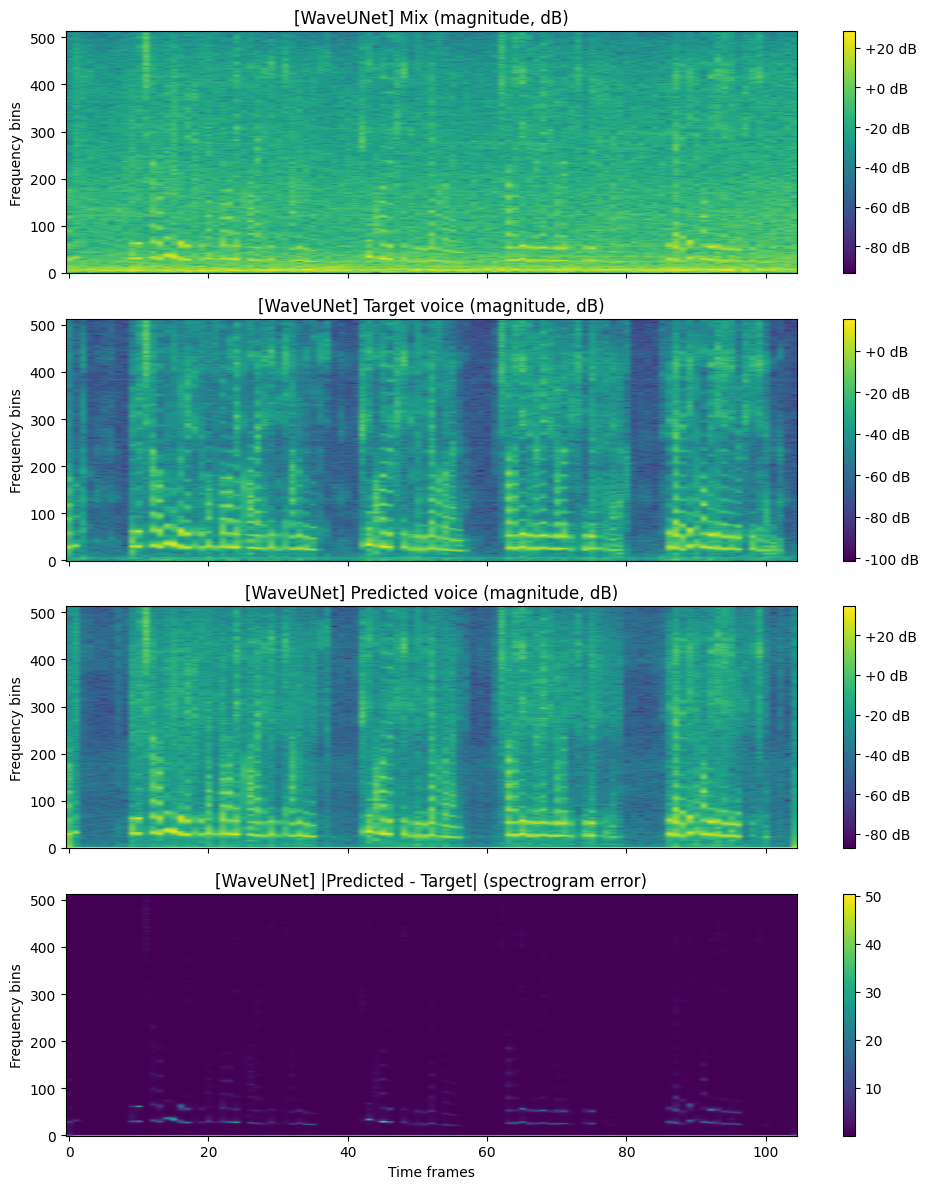

In [9]:
analyze_triplet("spectro_unet_skip_2d", title_prefix="[Skip 2D] ")
analyze_triplet("spectro_unet_orig", title_prefix="[Spectro Orig] ")
analyze_triplet("wave_unet", title_prefix="[WaveUNet] ")


High/low error energy ratio: 0.004308775
High error / high target energy: 2.1801734


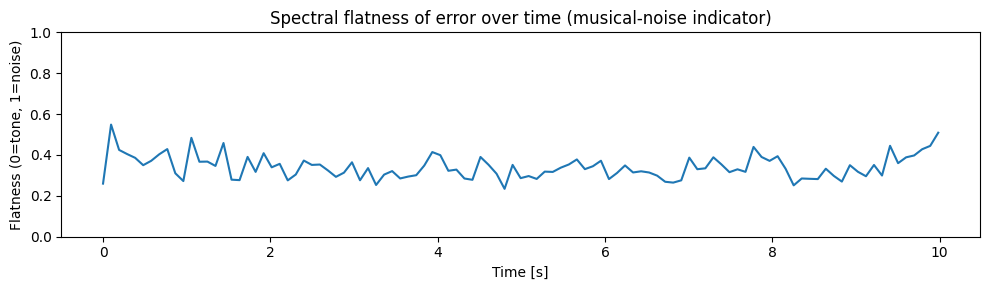

In [10]:
# 1) Band-wise error energy: is the error mostly high-frequency?
S_err = np.abs(spec_err)  # (F, T)
S_tgt = mag_target  # already abs

# Define a split frequency, e.g. 2 kHz
freqs = np.linspace(0, SR / 2, S_err.shape[0])
split_hz = 2000
split_bin = np.searchsorted(freqs, split_hz)

low_err = np.sum(S_err[:split_bin] ** 2)
high_err = np.sum(S_err[split_bin:] ** 2)
low_tgt = np.sum(S_tgt[:split_bin] ** 2)
high_tgt = np.sum(S_tgt[split_bin:] ** 2)

print("High/low error energy ratio:", high_err / (low_err + 1e-8))
print("High error / high target energy:", high_err / (high_tgt + 1e-8))

# 2) Spectral flatness of the error (noise-likeness)
#    Flatness ~1 → white-noise-like, ~0 → tone-like
from scipy.stats import gmean

flatness_per_frame = []
for t in range(S_err.shape[1]):
    mag_col = S_err[:, t] + 1e-8
    flatness_per_frame.append(gmean(mag_col) / (np.mean(mag_col) + 1e-8))
flatness_per_frame = np.array(flatness_per_frame)

times = librosa.frames_to_time(
    np.arange(len(flatness_per_frame)), sr=SR, hop_length=768
)

plt.figure(figsize=(10, 3))
plt.plot(times, flatness_per_frame)
plt.ylim(0, 1)
plt.title("Spectral flatness of error over time (musical-noise indicator)")
plt.xlabel("Time [s]")
plt.ylabel("Flatness (0=tone, 1=noise)")
plt.tight_layout()
plt.show()
